In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [2]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


In [3]:
# Ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is being used.')
else:
    print('GPU is not being used.')

GPU is being used.


In [4]:
# Path to the dataset
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List all the classes (Animal Types)
classes = os.listdir(dataset_path)
num_classes = len(classes)

# Display the number of classes along with names
print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')

Number of Classes: 90
Classes: ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']


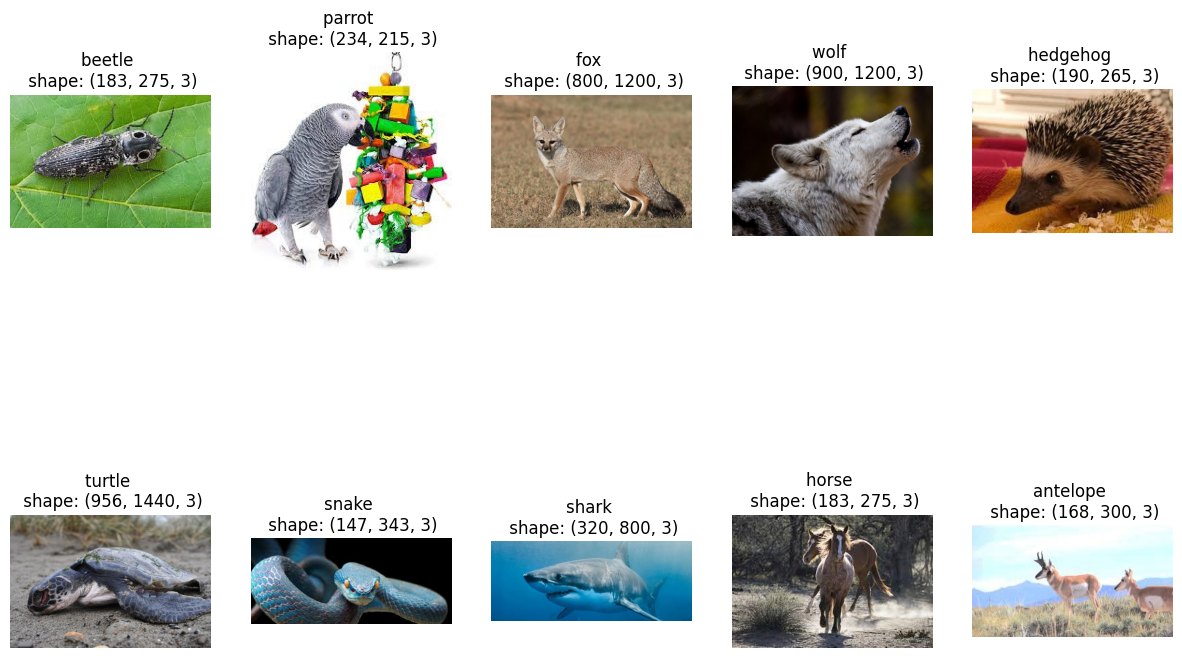

In [5]:
# Visualize some sample images form the dataset
plt.figure(figsize=(15,10))
for i, class_name in enumerate(classes[:10]):
  class_path = os.path.join(dataset_path, class_name)
  img_name = os.listdir(class_path)[0]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f'{class_name} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

<ipython-input-6-cfcdcb4df000>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Image Count", y="Class", data=df_counts, palette="viridis")


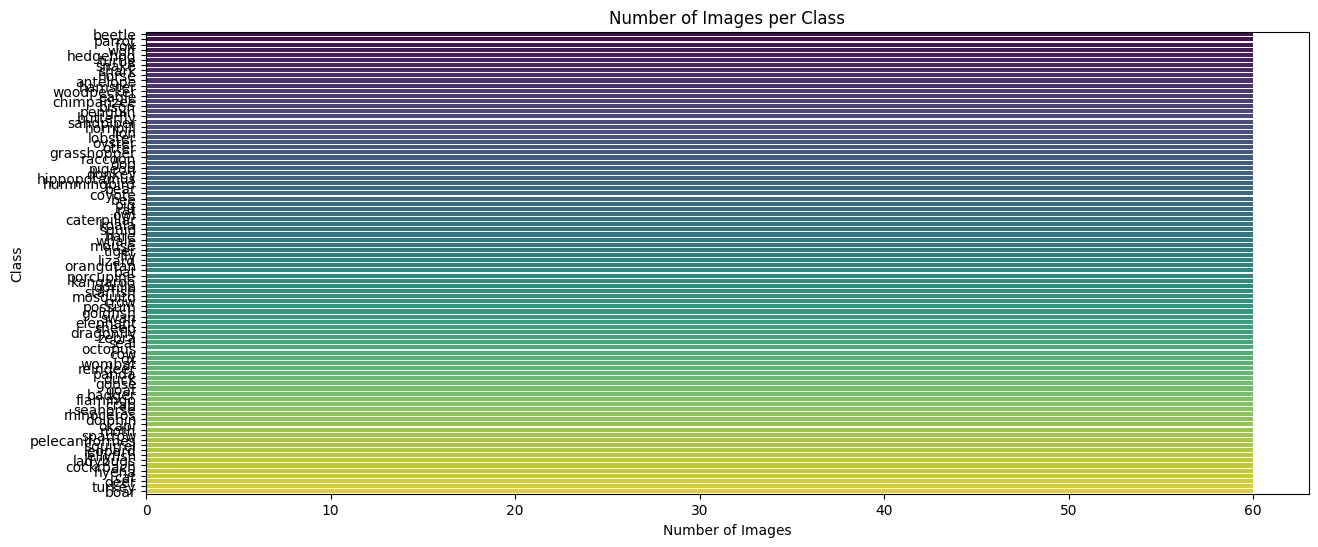

In [6]:
import seaborn as sns
import pandas as pd

# Count images in each class
class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}

# Convert to DataFrame for easy visualization
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_counts = df_counts.sort_values(by="Image Count", ascending=False)

# Plot distribution
plt.figure(figsize=(15, 6))
sns.barplot(x="Image Count", y="Class", data=df_counts, palette="viridis")
plt.xlabel("Number of Images")
plt.ylabel("Class")
plt.title("Number of Images per Class")
plt.show()


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Dataset Mean (RGB): [0.51675386 0.52151312 0.4546031 ]
Dataset Std Dev (RGB): [0.29177957 0.26960726 0.29850475]


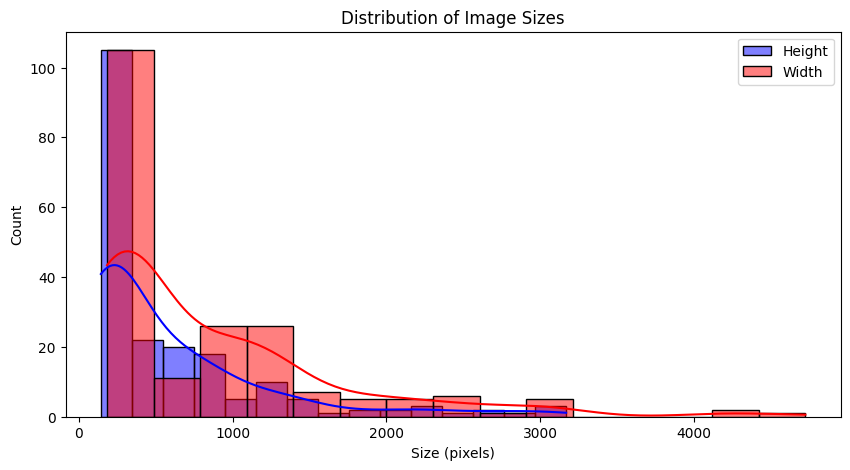

In [7]:
from tqdm import tqdm
import cv2

# Initialize mean and std accumulators
image_shapes = []
pixel_values = []

for class_name in tqdm(classes[:10]):  # Limiting to first 10 classes for efficiency
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)[:20]  # Sample 20 images per class for speed

    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        image_shapes.append(img.shape)  # Save image shape
        pixel_values.append(img / 255.0)  # Normalize and store pixel values

# Compute mean and standard deviation across all images
pixel_values = np.vstack([img.reshape(-1, 3) for img in pixel_values])
mean = np.mean(pixel_values, axis=0)
std = np.std(pixel_values, axis=0)

print(f"Dataset Mean (RGB): {mean}")
print(f"Dataset Std Dev (RGB): {std}")

# Plot distribution of image sizes
sizes = pd.DataFrame(image_shapes, columns=["Height", "Width", "Channels"])
plt.figure(figsize=(10, 5))
sns.histplot(sizes["Height"], kde=True, color="blue", label="Height")
sns.histplot(sizes["Width"], kde=True, color="red", label="Width")
plt.legend()
plt.title("Distribution of Image Sizes")
plt.xlabel("Size (pixels)")
plt.show()


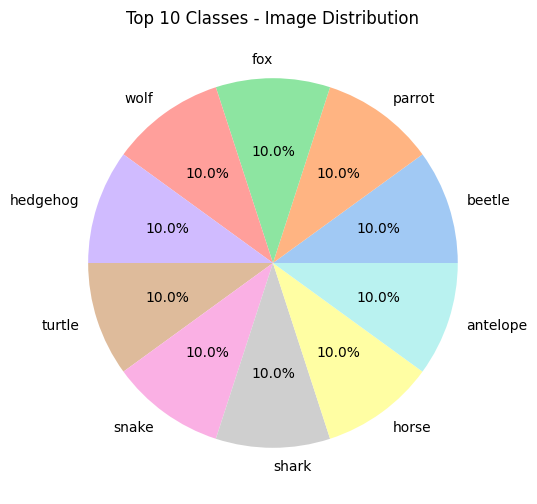

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}

# Convert to DataFrame for easy visualization
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_counts = df_counts.sort_values(by="Image Count", ascending=False)


# 🥧 Pie Chart for Top 10 Classes
top_10 = df_counts.head(10)
plt.figure(figsize=(10, 6))
plt.pie(top_10["Image Count"], labels=top_10["Class"], autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Top 10 Classes - Image Distribution")
plt.show()


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


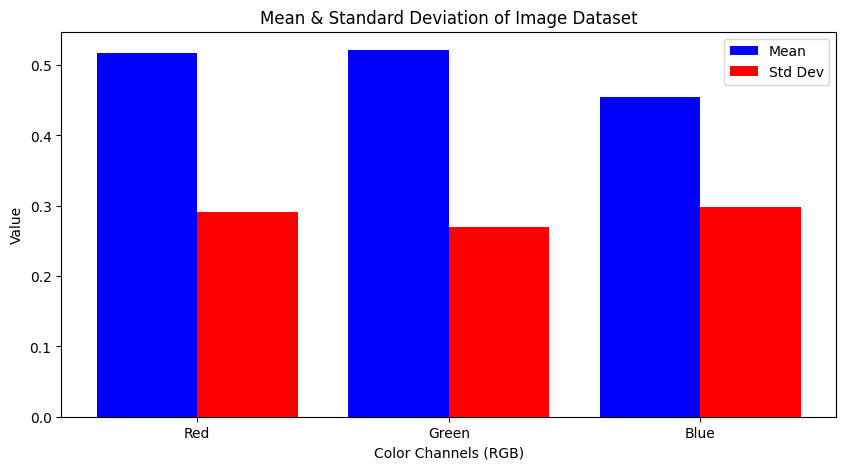

In [10]:
from tqdm import tqdm
import cv2
import numpy as np

# Initialize mean and std accumulators
pixel_values = []

for class_name in tqdm(classes[:10]):  # Limiting to first 10 classes for efficiency
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)[:20]  # Sample 20 images per class for speed

    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        pixel_values.append(img / 255.0)  # Normalize and store pixel values

# Compute mean and standard deviation across all images
pixel_values = np.vstack([img.reshape(-1, 3) for img in pixel_values])
mean = np.mean(pixel_values, axis=0)
std = np.std(pixel_values, axis=0)

# 📊 Bar Graph for Mean & Std Dev
plt.figure(figsize=(10, 5))
bar_width = 0.4
index = np.arange(3)

plt.bar(index, mean, bar_width, label="Mean", color="blue")
plt.bar(index + bar_width, std, bar_width, label="Std Dev", color="red")

plt.xlabel("Color Channels (RGB)")
plt.ylabel("Value")
plt.xticks(index + bar_width / 2, ["Red", "Green", "Blue"])
plt.title("Mean & Standard Deviation of Image Dataset")
plt.legend()
plt.show()


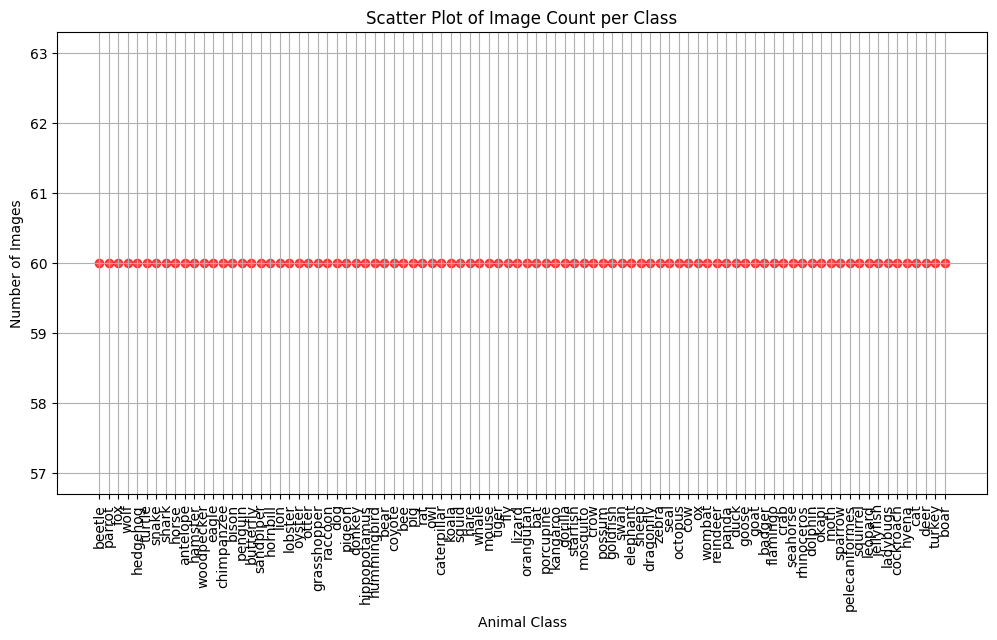

In [11]:
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Count images in each class
class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}

# Convert to DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_counts = df_counts.sort_values(by="Image Count", ascending=False)

# 📍 Scatter Plot for Image Distribution
plt.figure(figsize=(12, 6))
plt.scatter(df_counts["Class"], df_counts["Image Count"], color="red", alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel("Animal Class")
plt.ylabel("Number of Images")
plt.title("Scatter Plot of Image Count per Class")
plt.grid()
plt.show()

# 📊 Interactive Plotly Bar Chart
fig = px.bar(df_counts, x="Class", y="Image Count", title="Interactive Bar Chart of Image Count",
             labels={"Class": "Animal Type", "Image Count": "Number of Images"},
             color="Image Count", color_continuous_scale="blues")
fig.show()


100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


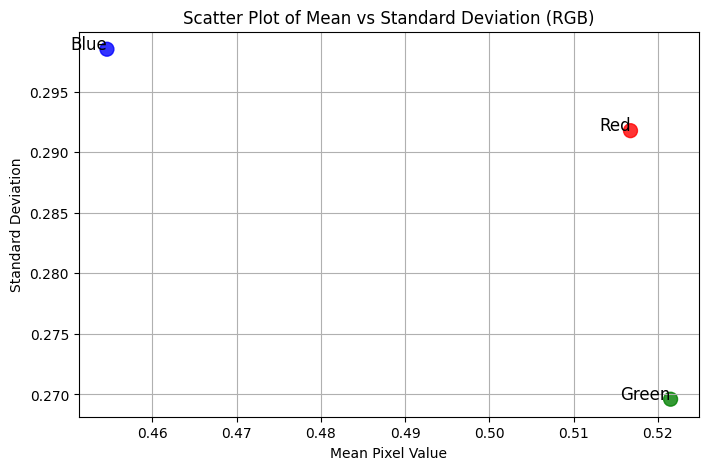

In [12]:
import numpy as np
import cv2
from tqdm import tqdm

# Collect pixel values for mean/std calculation
pixel_values = []

for class_name in tqdm(classes[:10]):  # Limiting to 10 classes for efficiency
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)[:20]  # Sample 20 images per class

    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        pixel_values.append(img / 255.0)  # Normalize and store pixel values

# Compute mean and standard deviation
pixel_values = np.vstack([img.reshape(-1, 3) for img in pixel_values])
mean = np.mean(pixel_values, axis=0)
std = np.std(pixel_values, axis=0)

# 📍 Scatter Plot for Mean vs Std Dev
plt.figure(figsize=(8, 5))
plt.scatter(mean, std, c=["red", "green", "blue"], s=100, alpha=0.8)
for i, label in enumerate(["Red", "Green", "Blue"]):
    plt.text(mean[i], std[i], label, fontsize=12, ha="right")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Standard Deviation")
plt.title("Scatter Plot of Mean vs Standard Deviation (RGB)")
plt.grid()
plt.show()

# 📊 Interactive Plotly Bar Chart for RGB Mean & Std Dev
df_rgb = pd.DataFrame({"Channel": ["Red", "Green", "Blue"], "Mean": mean, "Std Dev": std})

fig = px.bar(df_rgb, x="Channel", y=["Mean", "Std Dev"], barmode="group",
             title="RGB Mean & Standard Deviation",
             labels={"value": "Pixel Value", "variable": "Metric"})
fig.show()
